**1. Read & Load data into Python**

In [1]:
!pip uninstall pandas gast tensorboard tensorflow-estimator -y
!pip install pandas gast==0.2.2 tensorboard==2.1.0 tensorflow-estimator==2.1.0 tensorflow-gpu==2.1.0
import pandas as pd
import numpy as np
import io
import os

Uninstalling pandas-1.1.5:
  Successfully uninstalled pandas-1.1.5
Uninstalling gast-0.2.2:
  Successfully uninstalled gast-0.2.2
Uninstalling tensorboard-2.1.0:
  Successfully uninstalled tensorboard-2.1.0
Uninstalling tensorflow-estimator-2.1.0:
  Successfully uninstalled tensorflow-estimator-2.1.0
  Using cached https://files.pythonhosted.org/packages/c3/e2/00cacecafbab071c787019f00ad84ca3185952f6bb9bca9550ed83870d4d/pandas-1.1.5-cp36-cp36m-manylinux1_x86_64.whl
Processing /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd/gast-0.2.2-cp36-none-any.whl
  Using cached https://files.pythonhosted.org/packages/40/23/53ffe290341cd0855d595b0a2e7485932f473798af173bbe3a584b99bb06/tensorboard-2.1.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/18/90/b77c328a1304437ab1310b463e533fa7689f4bfc41549593056d812fab8e/tensorflow_estimator-2.1.0-py2.py3-none-any.whl
ERROR: tensorflow 2.6.2 has requirement gast==0.4.0, but you'll have gast 0.2.2

In [2]:
# Import TF/keras packages
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [3]:
path_training = 'gender_images/Training/'
path_validation = 'gender_images/Validation/'

In [6]:
# folder_images_train_F = r"/content/drive/MyDrive/DAAN 570 Deep Learning Project/gender_images/Training/female"
# folder_images_train_M = r"/content/drive/MyDrive/DAAN 570 Deep Learning Project/gender_images/Training/male"
# folder_images_test_F = r"/content/drive/MyDrive/DAAN 570 Deep Learning Project/gender_images/Validation/female"
# folder_images_test_M = r"/content/drive/MyDrive/DAAN 570 Deep Learning Project/gender_images/Validation/male"
# female_train_img_list = []
# male_train_img_list = []
# female_test_img_list = []
# male_test_img_list = []

In [7]:
# def FolderImages(pathvar, imglistname):
#    for dirpath, _, filenames in os.walk(pathvar):
#        for path_image in filenames:
#             image = os.path.abspath(os.path.join(dirpath, path_image))
#             with Image.open(image) as img:
#                 width, height = img.size
#                 imglistname.append(
#                     {
#                         'image': path_image,
#                         'width': width,
#                         'height': height
#                     }
#                 )
#                 pd.DataFrame(imglistname)

# # Get image dimensions into a list
# FolderImages(folder_images_train_F, female_train_img_list)
# FolderImages(folder_images_train_M, male_train_img_list)
# FolderImages(folder_images_test_F, female_test_img_list)
# FolderImages(folder_images_test_M, male_test_img_list)

In [8]:
image_size = (90, 90)
batch_size = 128

# Read in all image files and split into training/validation sets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(path_training,
                                                               seed=1993, 
                                                               image_size = image_size,
                                                               batch_size = batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(path_validation,
                                                             seed=1993,
                                                             image_size = image_size,
                                                             batch_size = batch_size)

one_hot_encoded_train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))
one_hot_encoded_val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))

Found 47009 files belonging to 2 classes.
Found 11649 files belonging to 2 classes.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimenta

In [9]:
one_hot_encoded_val_ds

<MapDataset shapes: ((None, 90, 90, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

inputs = keras.Input(shape=image_size)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

In [11]:
# Normalize images
# normalization_layer = tf.keras.layers.Rescaling(1./255)

# normalized_train_img = zoo_training.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_train_img))
# normalized_valid_img = zoo_validation.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_valid_img))

In [12]:
one_hot_encoded_train_ds = one_hot_encoded_train_ds.prefetch(buffer_size=32)
one_hot_encoded_val_ds = one_hot_encoded_val_ds.prefetch(buffer_size=32)

**2. Build a model based on a convolutional neural network (use softmax as output activation function and categorical_crossentropy as a loss function).**

In [13]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [14]:
epochs = 15

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 90, 90, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 90, 90)       0           input_2[0][0]                    
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 90, 90, 3)    0           sequential[1][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 45, 45, 32)   896         rescaling_1[0][0]                
______________________________________________________________________________________________

In [16]:
face_fit = model.fit(
  one_hot_encoded_train_ds,
  validation_data= one_hot_encoded_val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
368/368 [==============================] - ETA: 0s - loss: 0.2289 - accuracy: 0.9103WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f69b8234bf8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


368/368 [==============================] - 565s 2s/step - loss: 0.1413 - accuracy: 0.9487 - val_loss: 1.1417 - val_accuracy: 0.6620
Epoch 3/15
368/368 [==============================] - 553s 2s/step - loss: 0.1247 - accuracy: 0.9546 - val_loss: 0.1403 - val_accuracy: 0.9560
Epoch 4/15
368/368 [==============================] - 548s 1s/step - loss: 0.1158 - accuracy: 0.9588 - val_loss: 0.1022 - val_accuracy: 0.9624
Epoch 5/15
368/368 [==============================] - 539s 1s/step - loss: 0.1098 - accuracy: 0.9610 - val_loss: 0.1464 - val_accuracy: 0.9518
Epoch 6/15
368/368 [==============================] - 537s 1s/step - loss: 0.1075 - accuracy: 0.9613 - val_loss: 0.1157 - val_accuracy: 0.9615
Epoch 7/15
368/368 [==============================] - 537s 1s/step - loss: 0.1032 - accuracy: 0.9632 - val_loss: 0.1017 - val_accuracy: 0.9644
Epoch 8/15
368/368 [==============================] - 531s 1s/step - loss: 0.0996 - accuracy: 0.9638 - val_loss: 0.1885 - val_accuracy: 0.9405
Epoch 9/15

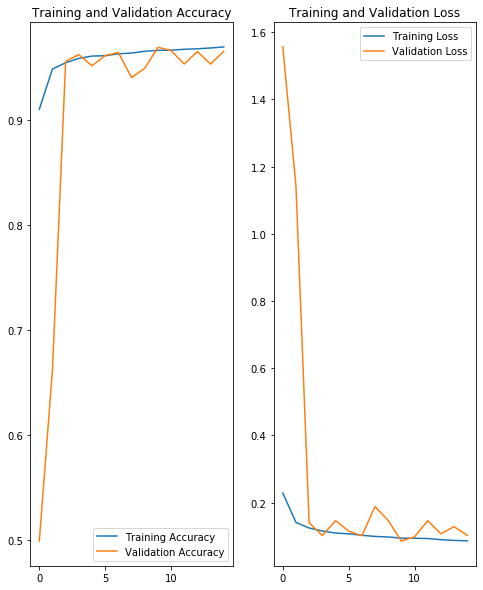

In [17]:
acc= face_fit.history['accuracy']
val_acc = face_fit.history['val_accuracy']

loss = face_fit.history['loss']
val_loss = face_fit.history['val_loss']

import matplotlib.pyplot as plt

epochs_range = range(epochs)

plt.figure(figsize=(8, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [36]:
filepath = 'gender_images/weights/'

In [45]:
face_fit_weights = model.get_weights()

with open('gender_images/weights/model_1.txt', 'w') as f:
    f.write(str(face_fit_weights))

In [47]:
model.save_weights(filepath, overwrite=True, save_format='tf', options=None)